# Micrograd
**Link**: https://github.com/karpathy/micrograd

1. Micrograd is an autograd (automatic gradient) engine i.e. it implements backpropagation.
2. **Backpropagation**: efficiently calculates the gradient of a loss function, with respect to the parameters of a neural network. This allows us to iteratively tune the parameters of the neural network to minimize the loss function and thereby improve the accuracy of the network.
3. Micrograd allows us to build mathematical expressions as compute graphs. Imagine a compute graph with `x1`, `w1`, and `w0` nodes as input values. The parent layer node `w1x1` is a multiplication (`*`) operator that calculates and stores the product of `x1` and `w1`. The grandparent layer `z` is an addition operator (`+`) that sums the values in nodes `w1x1` and `w0`. This compute graph represents a _weighted linear combination_ ($z=w_1\cdot x_1+w_0$). If you add another node `a` on top of the weighted linear combination that non-linearly squashes the value of `z` within some fixed range, e.g. sigmoid ($\sigma(z)$), hyperbolic tangent ($\text{tanh}(z)$), rectified linear unit ($\text{relu}(z)$), you get a _perceptron_. We could additionally place a loss function node on top of `a` and the true label, to evaluate the accuracy of the perceptron.
    1. Forward pass value of node `a` is stored in the `a.data` variable.
    2. To run backpropagation starting at node `a` use the `a.backward()` method, which applies the chain rule from calculus, i.e. the derivative of `a` with respect to each internal node and inputs (`a`, `z`, `w1x1`, `x1`, `w1`, and `w0`).
    3. The backward pass values, i.e. the gradients, are stored in the `grad` variable e.g., `w1.grad` contains $\frac{da}{dw_1}$. The gradient tells us how `w1` affects `a` i.e., if we slightly increment `w1`, how much would `a` change by?
        * $\frac{da}{da} = 1$; trivial and irrelevant for training neural networks.
        * $\frac{da}{dx_1}$; derivative of the activation (or loss function) w.r.t. the data is not useful for training neural networks because the data is fixed.
        * $\frac{da}{dw_0}$, $\frac{da}{dw_1}$; derivatives of the activation (or loss function) w.r.t. the weights is useful for training neural networks because the weights can be tuned.
4. "Micrograd is all you need" to train neural networks. Everything else given by frameworks such as Torch and JAX is just computational efficiency.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

## Derivative

$$
L = \lim_{h \rightarrow 0} \frac{f(x + h) - f(x)}{h}
$$

### Univariate function

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

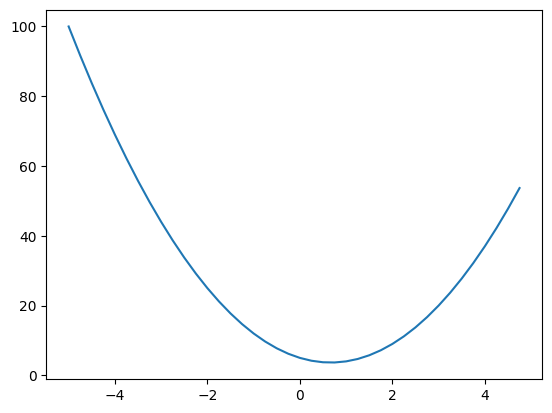

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 1e-6
x = 3.0

print(f"f(x): { f(x) }")
print(f"f(x + h): { f(x + h) }")
print(f"df(x)/dx: { (f(x + h) - f(x)) / h }")
print(f"6x - 4: { 6*x - 4 }")

f(x): 20.0
f(x + h): 20.000014000003002
df(x)/dx: 14.000003002223593
6x - 4: 14.0


### Multivariate function

$$
g(w_1, x_1, w_0) = w_1\cdot x_1 + w_0
$$

In [6]:
def g(w1, x1, w0):
    return w1 * x1 + w0

In [7]:
h = 1e-6
w1, x1, w0 = -3.0, 2.0, 7.0

print(f"g(w1, x1, w0): { g(w1, x1, w0) }")
print(f"g(w1 + h, x1, w0): { g(w1 + h, x1, w0)}")
print(f"dg(w1, x1, w0)/da: { (g(w1 + h, x1, w0) - g(w1, x1, w0)) / h }")
print(f"b: { x1 }")

g(w1, x1, w0): 1.0
g(w1 + h, x1, w0): 1.0000020000000003
dg(w1, x1, w0)/da: 2.000000000279556
b: 2.0


In [8]:
h = 1e-6
w1, x1, w0 = -3.0, 2.0, 7.0

print(f"d(w1, x1, w0): { g(w1, x1, w0) }")
print(f"d(w1, x1 + h, w0): { g(w1, x1 + h, w0) }")
print(f"dg(w1, x1, w0)/db: { (g(w1, x1 + h, w0) - g(w1, x1, w0)) / h }")
print(f"a: { w1 }")

d(w1, x1, w0): 1.0
d(w1, x1 + h, w0): 0.9999969999999996
dg(w1, x1, w0)/db: -3.000000000419334
a: -3.0


In [9]:
h = 1e-6
w1, x1, w0 = -3.0, 2.0, 7.0

print(f"g(w1, x1, w0): { g(w1, x1, w0) }")
print(f"g(w1, x1, w0 + h): { g(w1, x1, w0 + h) }")
print(f"dg(w1, x1, w0)/dc: { (g(w1, x1, w0 + h) - g(w1, x1, w0)) / h }")
print(f"1: { 1 }")

g(w1, x1, w0): 1.0
g(w1, x1, w0 + h): 1.0000010000000001
dg(w1, x1, w0)/dc: 1.000000000139778
1: 1


## Building mathematical expressions

1. The main thing to remember when implementing an operator for the `Value` object is to know how to compute the local derivative i.e. the gradient of the node output w.r.t. to each of its children. Otherwise, the operator can be at any level of abstraction (implementing the components of tanh i.e. exponent, addition, subtraction, division vs. implementing tanh directly).

In this example, we will build a perceptron.

In [10]:
from micrograd.engine import Value

### Manual gradient calculation

Using the chain rule in calculus—
* $\frac{da}{da} = 1$: trivial case.
* $a = \text{tanh}(z)$: _tanh_ activation.
    * $\frac{da}{dz}=\frac{d}{dz}\text{tanh}\, z = 1-\text{tanh}^2z = 1-(0.7616)^2 = 0.42$.
* $z = w_1x_1 + x_0$: linear combination.
    * $\frac{da}{dw1x1} = \frac{da}{dz}\cdot\frac{dz}{dw1x1}=0.42\cdot 1=0.42$: locally, if you increment a summation term by some amount, the overall sum will increase by that same amount.
    * $\frac{da}{dw_0} = \frac{da}{dz}\cdot\frac{dz}{dw_0}=0.42\cdot 1=0.42$: same as above.
* $w_1x_1 = w_1\cdot x_1$: product.
    * $\frac{da}{dx_1} = \frac{da}{dz}\cdot\frac{dz}{dw1x1}\cdot\frac{w1x1}{dx_1} = 0.42\cdot 1\cdot w_1 = 0.42\cdot -3 = -1.26$: locally, if you increase $x_1$ by a small amount, the product term will scale proportional to $w_1$.
    * $\frac{da}{dw_1} = \frac{da}{dz}\cdot\frac{dz}{dw1x1}\cdot\frac{w1x1}{dw_1} = 0.42\cdot 1\cdot x_1 = 0.42\cdot 2=0.84$: locally, if you increase $w_1$ by a small amount, the product term will scale proportional to $x_1$.

In summary,
* **Addition**: for each child, multiply its parent's gradient by 1.
* **Multiplication**: each child borrows the data value from its sibling and multiplies it with the parent's gradient.


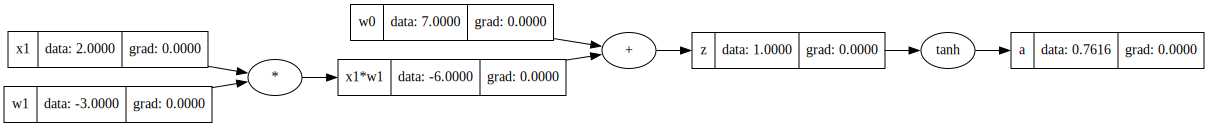

In [11]:
w1 = Value(-3.0, label='w1')
x1 = Value(2.0, label='x1')
w0 = Value(7.0, label='w0')
w1x1 = w1 * x1; w1x1.label = 'x1*w1'
z = w1x1 + w0; z.label = 'z'
a = z.tanh(); a.label = 'a'

a.plot()

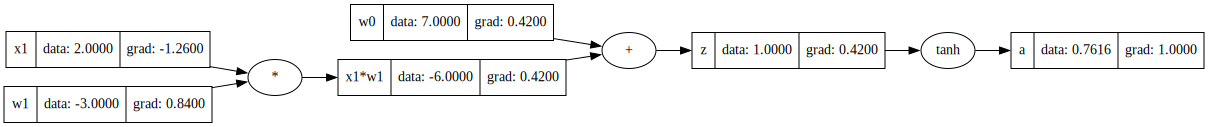

In [12]:
a.grad = 1  # da/da
z.grad = 0.42  # da/dz
w1x1.grad = z.grad * 1.0  # da/dw1x1
w0.grad = z.grad * 1.0  # da/dw0
x1.grad = w1x1.grad * w1.data  # da/dx1
w1.grad = w1x1.grad * x1.data  # da/dw1

a.plot()

### Automated gradient calculation

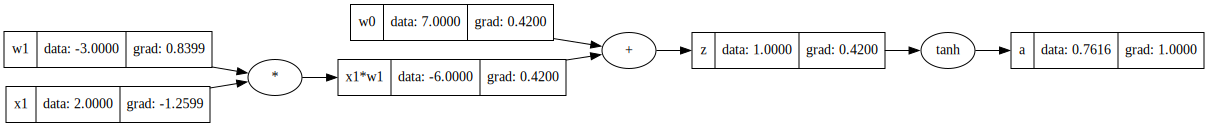

In [13]:
w1 = Value(-3.0, label='w1')
x1 = Value(2.0, label='x1')
w0 = Value(7.0, label='w0')
w1x1 = w1 * x1; w1x1.label = 'x1*w1'
z = w1x1 + w0; z.label = 'z'
a = z.tanh(); a.label = 'a'

a.backward()

a.plot()